In [13]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("database/coingecko.db")
df = pd.read_sql("SELECT * FROM crypto_prices", conn)
print(df.tail())
conn.close()

             id symbol      name       price   market_cap       volume  \
80  binancecoin    bnb       BNB  672.200000  98065811485    942829688   
81       solana    sol    Solana  166.140000  87370792449   5091056795   
82     usd-coin   usdc      USDC    0.999768  60940431277  11817537507   
83     dogecoin   doge  Dogecoin    0.201115  30121454267   1692627898   
84      cardano    ada   Cardano    0.718715  25940364910    805871440   

    pct_change_24h                   timestamp  
80         1.84405  2025-06-11 11:35:41.060674  
81         4.84714  2025-06-11 11:35:41.060674  
82        -0.00242  2025-06-11 11:35:41.060674  
83         4.98620  2025-06-11 11:35:41.060674  
84         3.43722  2025-06-11 11:35:41.060674  


In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib

Import Libraries

In [15]:
df = pd.read_csv("data/processed/crypto_cleaned.csv")
df.head()

,id,symbol,name,price,market_cap,volume,pct_change_24h,timestamp
0,bitcoin,btc,Bitcoin,109457.000000,2176518444626,32651103716,0.00153,2025-06-11 11:35:41.060674
1,ethereum,eth,Ethereum,2770.670000,334431259478,34117714543,2.99029,2025-06-11 11:35:41.060674
2,tether,usdt,Tether,0.999968,155177578967,40802276908,-0.03208,2025-06-11 11:35:41.060674
3,binancecoin,bnb,BNB,672.200000,98065811485,942829688,1.84405,2025-06-11 11:35:41.060674
4,solana,sol,Solana,166.140000,87370792449,5091056795,4.84714,2025-06-11 11:35:41.060674


Loading the data

In [17]:
X = df[["market_cap", "volume", "pct_change_24h"]]
y = df["price"]

Features selection

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Train-test split

In [19]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Random Forest Model

In [20]:
y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.3f}")

RMSE: 2453.16
R² Score: 0.997


c:\Users\Legion\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Evaluate the model

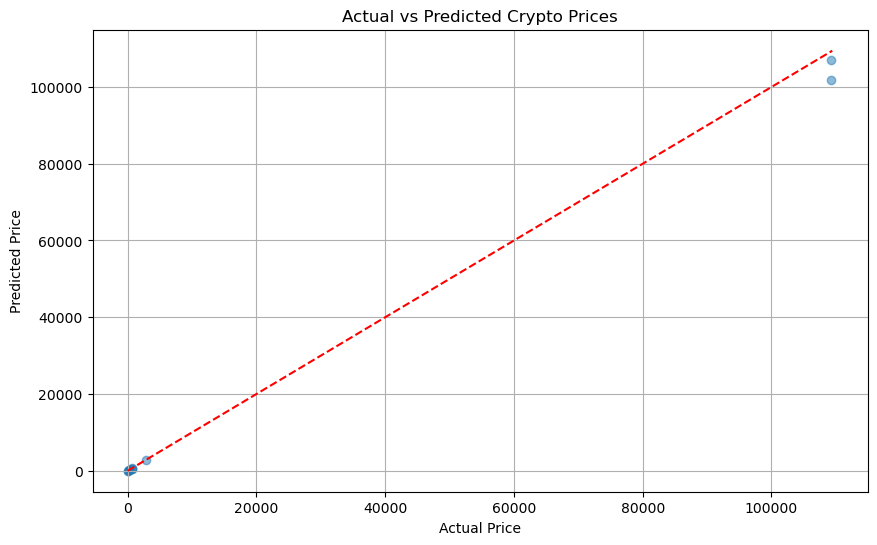

In [21]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Crypto Prices")
plt.grid()
plt.show()

Actual vs Predicted

In [22]:
joblib.dump(model, "crypto_price_model.pkl")

['crypto_price_model.pkl']

In [27]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import joblib

# Load data
df = pd.read_csv("data/processed/crypto_cleaned.csv")

# Keep only the latest data per coin
latest_timestamps = df.groupby("symbol")["timestamp"].transform("max")
df = df[df["timestamp"] == latest_timestamps]

# Filter top 5 coins by market cap (or change to top 5 by volume if you prefer)
top5 = df.groupby("symbol")["market_cap"].mean().nlargest(5).index.tolist()
df = df[df["symbol"].isin(top5)]

# Define features and target
X = df[["symbol", "market_cap", "volume", "pct_change_24h"]]
y = df["price"]

# One-hot encode the 'symbol' column
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_encoded = encoder.fit_transform(X[["symbol"]])

# Combine encoded symbols with numeric features
X_final = pd.concat([
    pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(["symbol"])),
    X[["market_cap", "volume", "pct_change_24h"]].reset_index(drop=True)
], axis=1)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse:.4f}")

# Save model and encoder
joblib.dump(model, "crypto_price_model.pkl")
joblib.dump(encoder, "crypto_encoder.pkl")

RMSE: 12736.6662


c:\Users\Legion\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


['crypto_encoder.pkl']

Retraining